In [1]:
import cellxgene_census
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from datetime import timedelta

import requests
import concurrent.futures

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [17]:
census = cellxgene_census.open_soma(census_version="2024-04-01") # current "latest" is "2024-04-01"
census['census_info']['summary'].read().concat().to_pandas()

,soma_joinid,label,value
0,0,census_schema_version,2.0.0
1,1,census_build_date,2024-04-01
2,2,dataset_schema_version,5.0.0
3,3,total_cell_count,114405937
4,4,unique_cell_count,59761180
5,5,number_donors_homo_sapiens,17082
6,6,number_donors_mus_musculus,4186


In [18]:
mus = (
    census["census_data"]['mus_musculus']
    .obs.read(
        value_filter="is_primary_data==True",
        column_names=['dataset_id', 'nnz']
    )
    .concat()
    .to_pandas()
)

homo = (
    census["census_data"]['homo_sapiens']
    .obs.read(
        value_filter="is_primary_data==True",
        column_names=['dataset_id', 'nnz']
    )
    .concat()
    .to_pandas()
)

In [19]:
# mouse/human datasets
mus_ds_id = mus['dataset_id'].unique()
homo_ds_id = homo['dataset_id'].unique()

# dataset metadata
ds_meta = census['census_info']['datasets'].read().concat().to_pandas()
ds_meta = ds_meta[ds_meta['dataset_id'].isin(np.concatenate([mus_ds_id, homo_ds_id]))]

# filter for mouse/human
ds_meta_mus = ds_meta[ds_meta['dataset_id'].isin(mus_ds_id)]
ds_meta_homo = ds_meta[ds_meta['dataset_id'].isin(homo_ds_id)]

In [20]:
def get_publication_date(doi):
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        pub_date = data['message'].get('created', {}).get('date-time')
        return pub_date
    else:
        return np.nan

with concurrent.futures.ThreadPoolExecutor() as executor:
    pub_dates = list(executor.map(get_publication_date, ds_meta['collection_doi'].unique()))

pub_dates = dict(zip(ds_meta['collection_doi'].unique(), pub_dates))

In [21]:
mus_nnz = mus.groupby('dataset_id')['nnz'].sum()
homo_nnz = homo.groupby('dataset_id')['nnz'].sum()
all_nnz = pd.concat([mus_nnz, homo_nnz])

/var/folders/tg/n7kwvm_x1kgdj1k46pvny2dw0000gn/T/ipykernel_70638/2047187899.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mus_nnz = mus.groupby('dataset_id')['nnz'].sum()
/var/folders/tg/n7kwvm_x1kgdj1k46pvny2dw0000gn/T/ipykernel_70638/2047187899.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  homo_nnz = homo.groupby('dataset_id')['nnz'].sum()


In [22]:
def process_dataset_meta(ds_meta, pub_dates, all_nnz):
    # Map publication dates
    ds_meta['pub_date'] = ds_meta['collection_doi'].map(pub_dates)
    ds_meta['pub_date'] = pd.to_datetime(ds_meta['pub_date'])

    # Remove missing publication dates
    ds_meta = ds_meta.dropna(subset=['pub_date'])

    # Merge with non-zero counts
    ds_meta = ds_meta.merge(all_nnz, left_on='dataset_id', right_index=True)

    # Group, sum, and reset index
    ds_meta = ds_meta.groupby(['collection_name', 'collection_id', 'collection_doi', 'pub_date'])[['dataset_total_cell_count', 'nnz']].sum().reset_index()
    ds_meta = ds_meta.rename(columns={'dataset_total_cell_count': 'collection_total_cell_count'})

    # Order by publication date
    ds_meta = ds_meta.sort_values(by='pub_date')

    # Calculate cumulative cell counts
    ds_meta['cum_cell_counts'] = ds_meta['collection_total_cell_count'].cumsum()

    # Calculate cumulative non-zero counts
    ds_meta['cum_nnz'] = ds_meta['nnz'].cumsum()

    return ds_meta


In [23]:
ds_meta = process_dataset_meta(ds_meta, pub_dates, all_nnz)
ds_meta_mus = process_dataset_meta(ds_meta_mus, pub_dates, all_nnz)
ds_meta_homo = process_dataset_meta(ds_meta_homo, pub_dates, all_nnz)

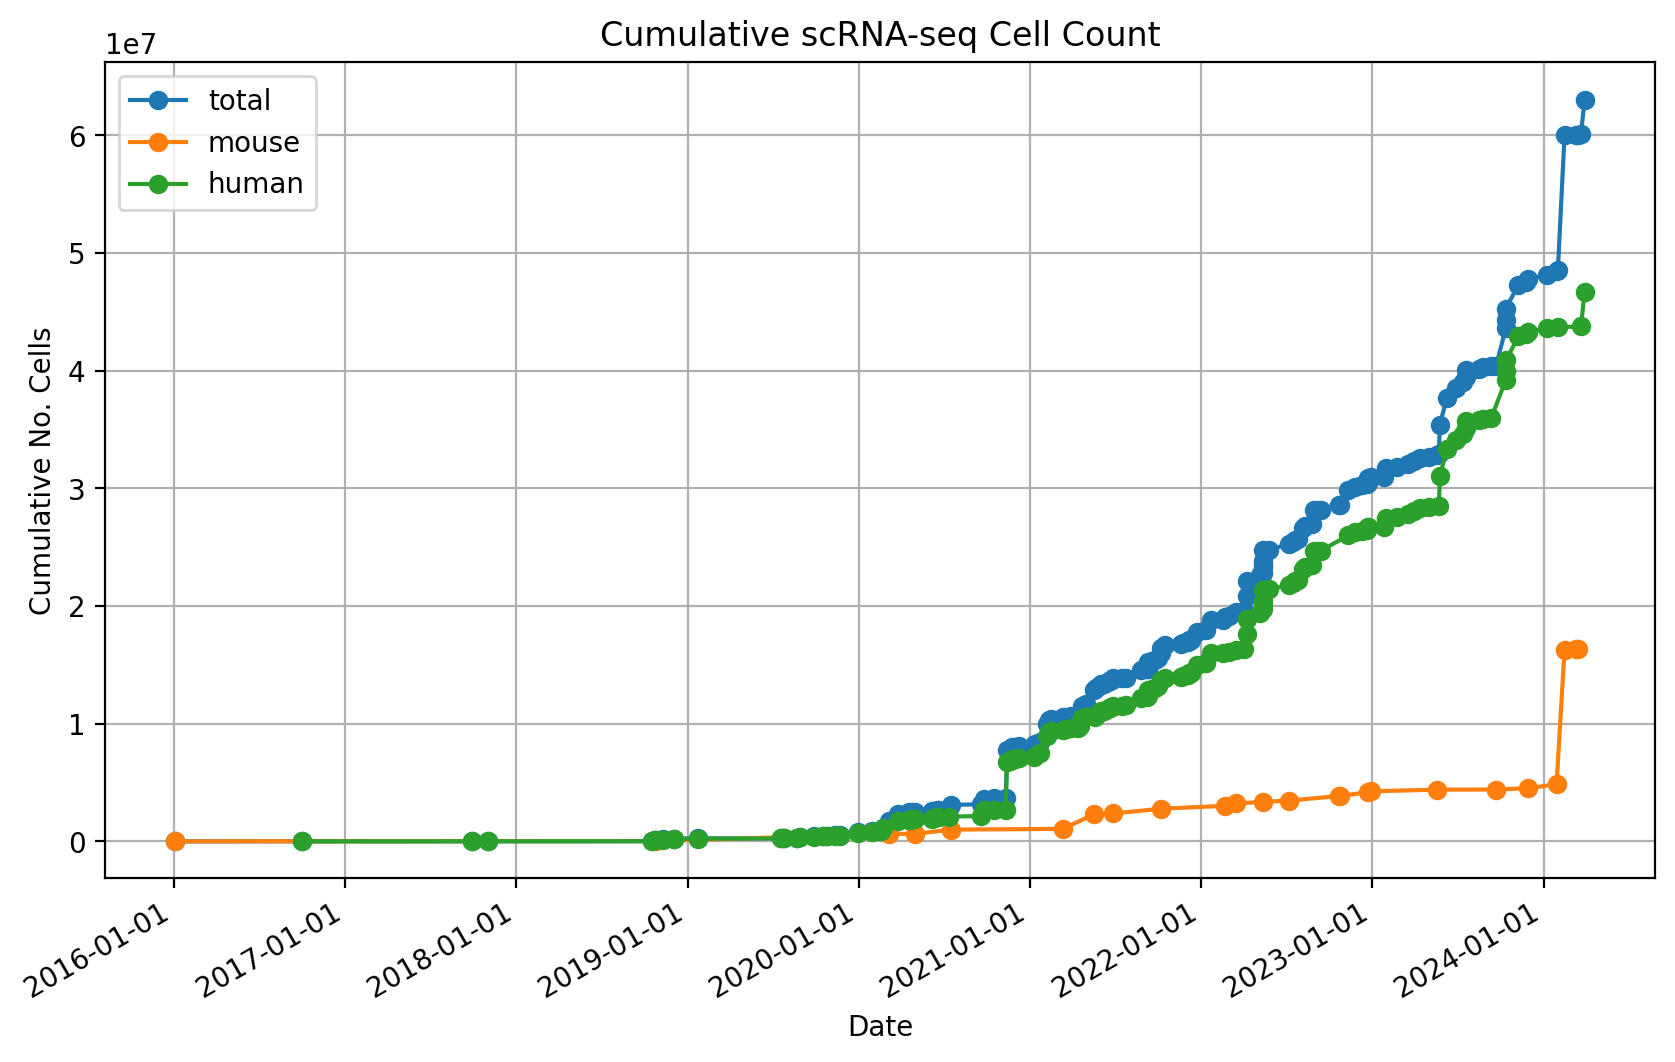

In [24]:
dataset_stats = {'total': ds_meta, 'mouse': ds_meta_mus, 'human': ds_meta_homo}

# Plotting
plt.figure(figsize=(10, 6))

for title,df in dataset_stats.items():
    plt.plot(df['pub_date'], df['cum_cell_counts'], marker='o', label=title)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative No. Cells')
plt.title('Cumulative scRNA-seq Cell Count')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format for better date label appearance
plt.show()

In [25]:
# notable collections
ds_meta.sort_values(by='collection_total_cell_count', ascending=False).head(10)

,collection_name,collection_id,collection_doi,pub_date,collection_total_cell_count,nnz,cum_cell_counts,cum_nnz
15,A single-cell transcriptional timelapse of mou...,45d5d2c3-bc28-4814-aed6-0bb6f0e11c82,10.1038/s41586-024-07069-w,2024-02-14 17:02:30+00:00,11441407,19538817097,59986799,120416918180
5,A human cell atlas of fetal gene expression,c114c20f-1ef4-49a5-9c2e-d965787fb90c,10.1126/science.aba7721,2020-11-12 19:05:24+00:00,4062980,2382172468,7758851,7817197314
55,Human Brain Cell Atlas v1.0,283d65eb-dd53-496d-adb7-7570c7caa443,10.1126/science.add7046,2023-10-12 14:00:31+00:00,3264757,15514176362,43636838,89463385938
56,Human breast cell atlas,48259aa8-f168-4bf5-b797-af8e88da6637,10.1038/s41588-024-01688-9,2024-03-28 11:01:45+00:00,2925348,2669158223,63041231,123269714130
91,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,1ca90a2d-2943-483d-b678-b809bf464c30,10.1101/2023.05.08.539485,2023-05-24 18:09:49+00:00,2536269,13823016395,35423641,65980229306
147,The integrated Human Lung Cell Atlas,6f6d381a-7701-4781-935c-db10d30de293,10.1038/s41591-023-02327-2,2023-06-08 16:01:46+00:00,2282447,3523823647,37706088,69504052953
99,Single cell atlas of the human retina,4c6eaf5c-6d57-4c76-b1e9-60df8c655f1e,10.1101/2023.11.07.566105,2023-11-08 11:05:13+00:00,2041296,3409128126,47320785,98575767620
29,COVID-19 immune features revealed by a large-s...,0a839c4b-10d0-4d64-9272-684c49a2c8ba,10.1016/j.cell.2021.01.053,2021-02-05 01:08:14+00:00,1462702,2308785031,9933692,11396178601
54,High-resolution single-cell atlas reveals dive...,edb893ee-4066-4128-9aec-5eb2b03f8287,10.1016/j.ccell.2022.10.008,2022-11-10 15:31:02+00:00,1283972,1298614950,29875079,47158881214
112,Single-cell RNA-seq reveals the cell-type-spec...,436154da-bcf1-4130-9c8b-120ff9a888f2,10.1126/science.abf1970,2022-04-07 17:55:41+00:00,1263676,1001478196,22099659,33185646317


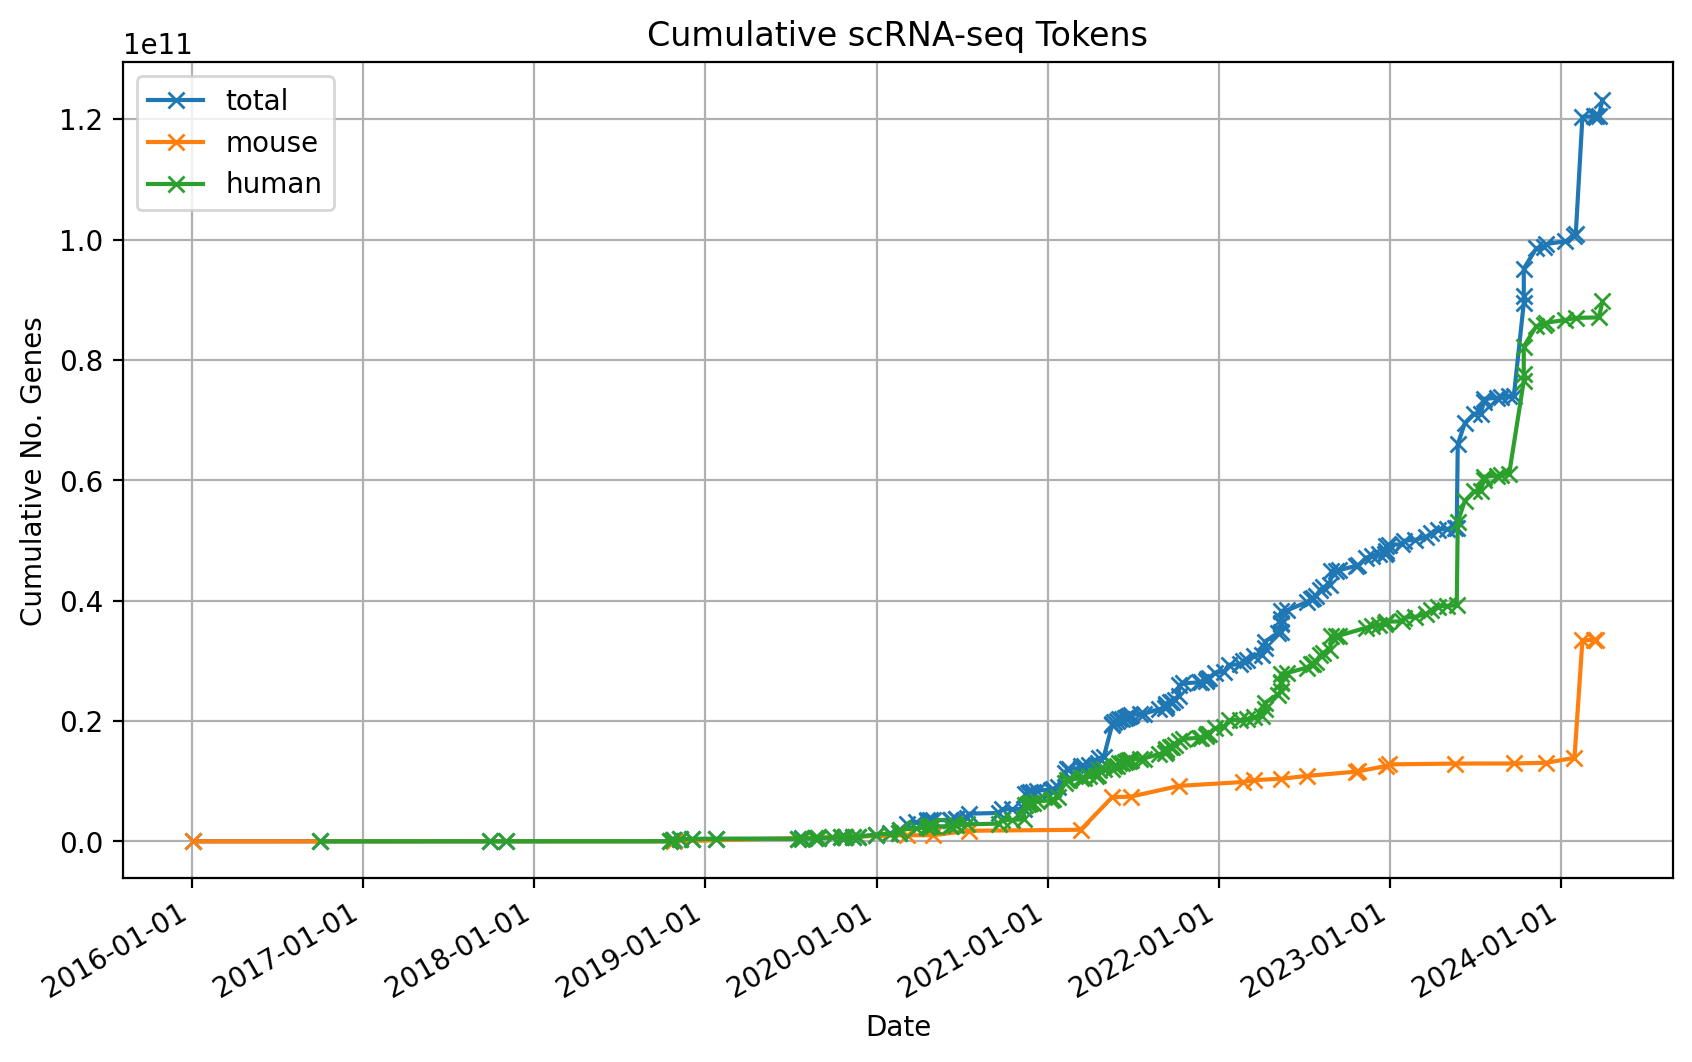

In [26]:
# Plotting
plt.figure(figsize=(10, 6))

for title,df in dataset_stats.items():
    plt.plot(df['pub_date'], df['cum_nnz'], marker='x', label=title)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative No. Genes')
plt.title('Cumulative scRNA-seq Tokens')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format for better date label appearance
plt.show()

In [27]:
print(f"Total number of tokens: {ds_meta['cum_nnz'].max():.3E}")

Total number of tokens: 1.233E+11


/Users/willconnell/miniconda3/envs/scaling-bio/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/willconnell/miniconda3/envs/scaling-bio/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


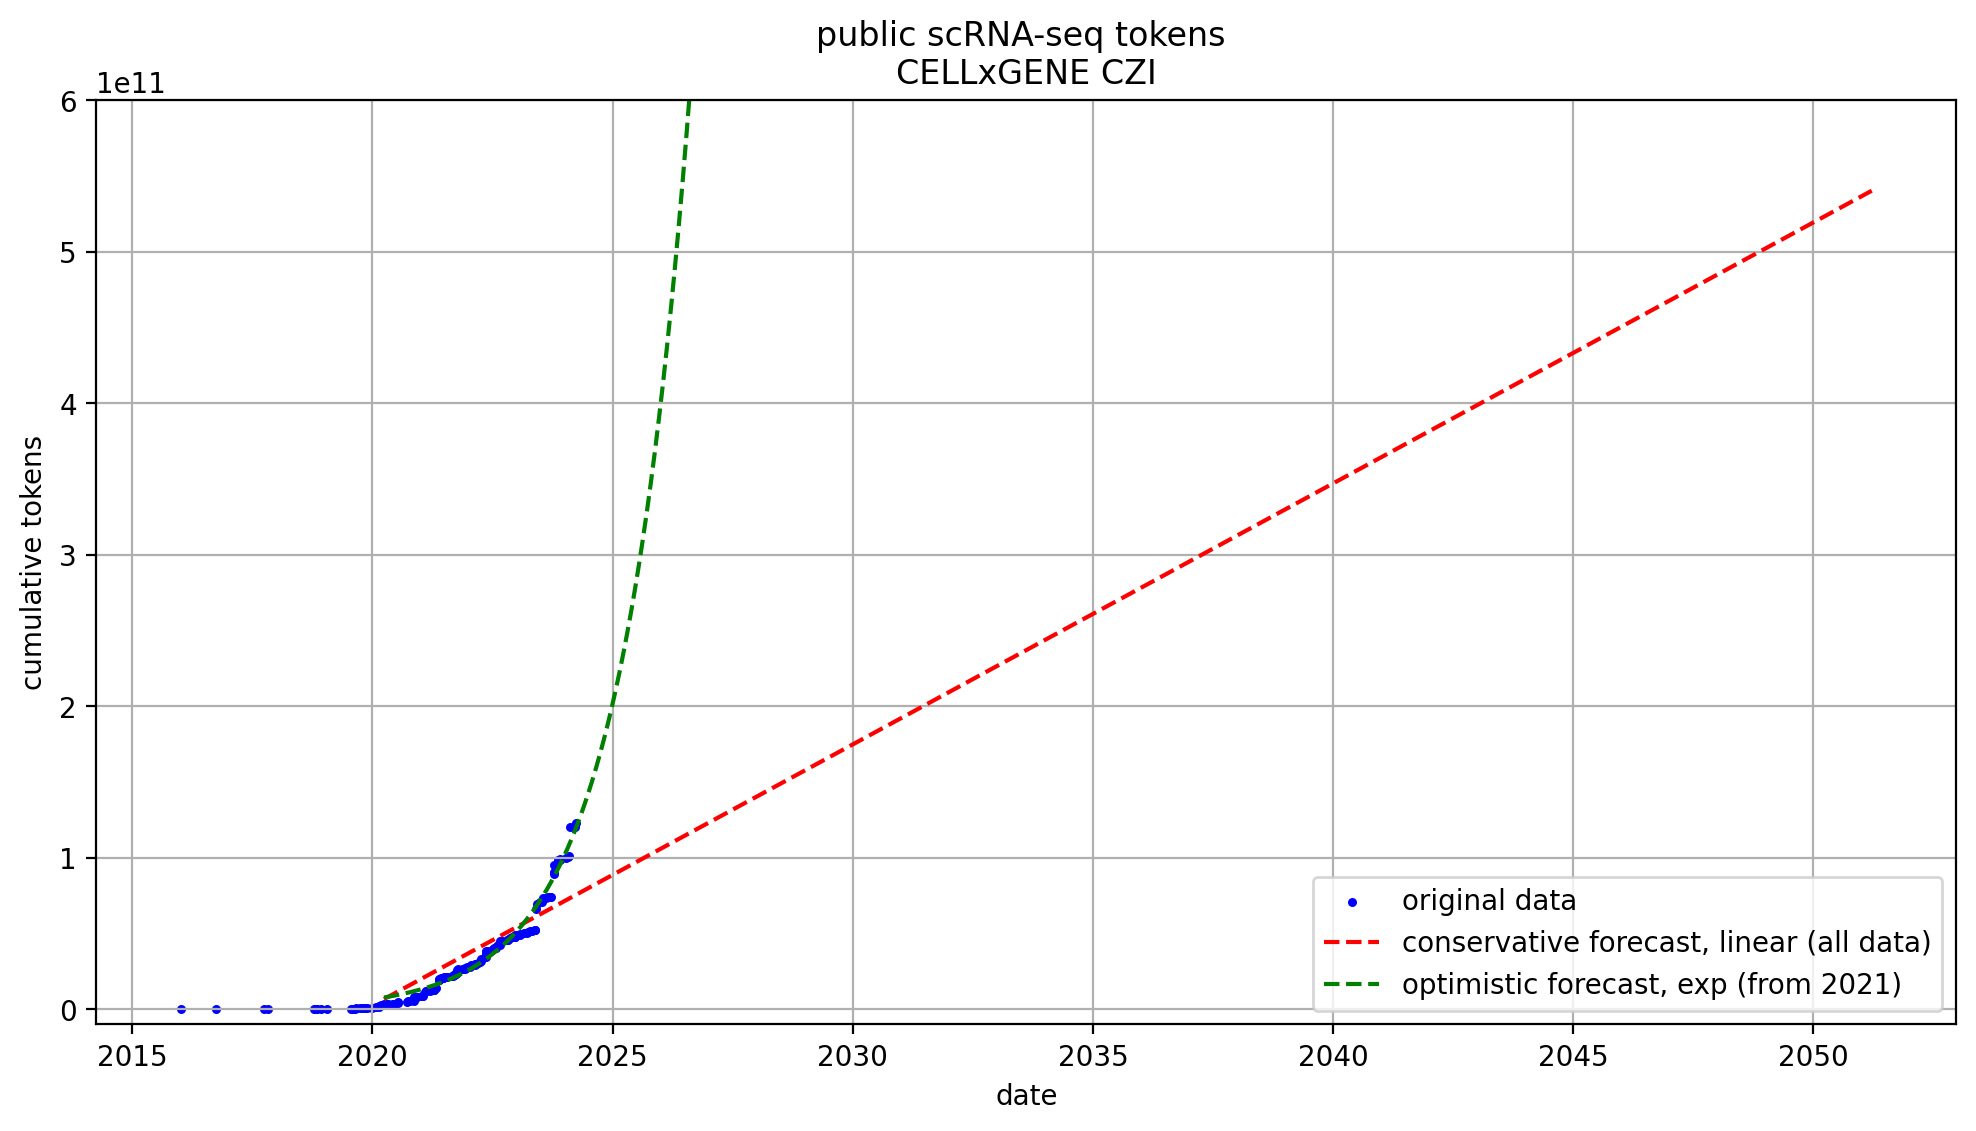

In [46]:
def fit_and_plot_models(ds_meta):
    # Ensure 'pub_date' is timezone-naive
    ds_meta['pub_date'] = ds_meta['pub_date'].dt.tz_localize(None)

    # Convert 'pub_date' to numeric (days since the earliest date)
    min_date = ds_meta['pub_date'].min()
    ds_meta['pub_date_numeric'] = (ds_meta['pub_date'] - min_date).dt.days

    # Prepare data for the linear model
    X = ds_meta[['pub_date_numeric']]
    y = ds_meta['cum_nnz']

    # Fit the linear model
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    # Predict ~25 years for the linear model
    max_date_numeric = ds_meta['pub_date_numeric'].max() - (4 * 365) # start ~2021
    future_dates_all = pd.Series(range(max_date_numeric, max_date_numeric + 31 * 365))
    future_linear_predictions = linear_model.predict(future_dates_all.to_frame())

    # Fit an exponential model using data from 2021 onwards
    start_2021 = (pd.Timestamp('2021-01-01') - min_date).days
    X_2021 = ds_meta[ds_meta['pub_date_numeric'] >= start_2021][['pub_date_numeric']]
    y_2021 = ds_meta[ds_meta['pub_date_numeric'] >= start_2021]['cum_nnz']

    # Transform y_2021 for the exponential model
    y_2021_log = np.log(y_2021)

    exponential_model = LinearRegression()
    exponential_model.fit(X_2021, y_2021_log)

    # Predict for the exponential model and transform back
    future_exponential_predictions_log = exponential_model.predict(future_dates_all.to_frame())
    future_exponential_predictions = np.exp(future_exponential_predictions_log)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(ds_meta['pub_date'], y, color='blue', label='original data', s=5)
    plt.plot([min_date + timedelta(days=int(d)) for d in future_dates_all], future_linear_predictions, color='red', label='conservative forecast, linear (all data)', linestyle='dashed')
    plt.plot([min_date + timedelta(days=int(d)) for d in future_dates_all], future_exponential_predictions, color='green', label='optimistic forecast, exp (from 2021)', linestyle='dashed')

    # Set x-axis to display every 5 years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.ylim((-1e10, 6e11))
    plt.xlabel('date')
    plt.ylabel('cumulative tokens')
    plt.title('public scRNA-seq tokens \nCELLxGENE CZI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
fit_and_plot_models(ds_meta)


### Chinchilla compute-optimal model for current datasets

In [85]:
def chincilla_sl(n, d):
    return (406.4 / n ** 0.34) + (410.7 / d ** 0.28) + 1.69

d_static = ds_meta['cum_nnz'].max()
n_range = np.linspace(1e6, 1e12, 1*10**6)

losses = [chincilla_sl(n, d_static) for n in n_range]

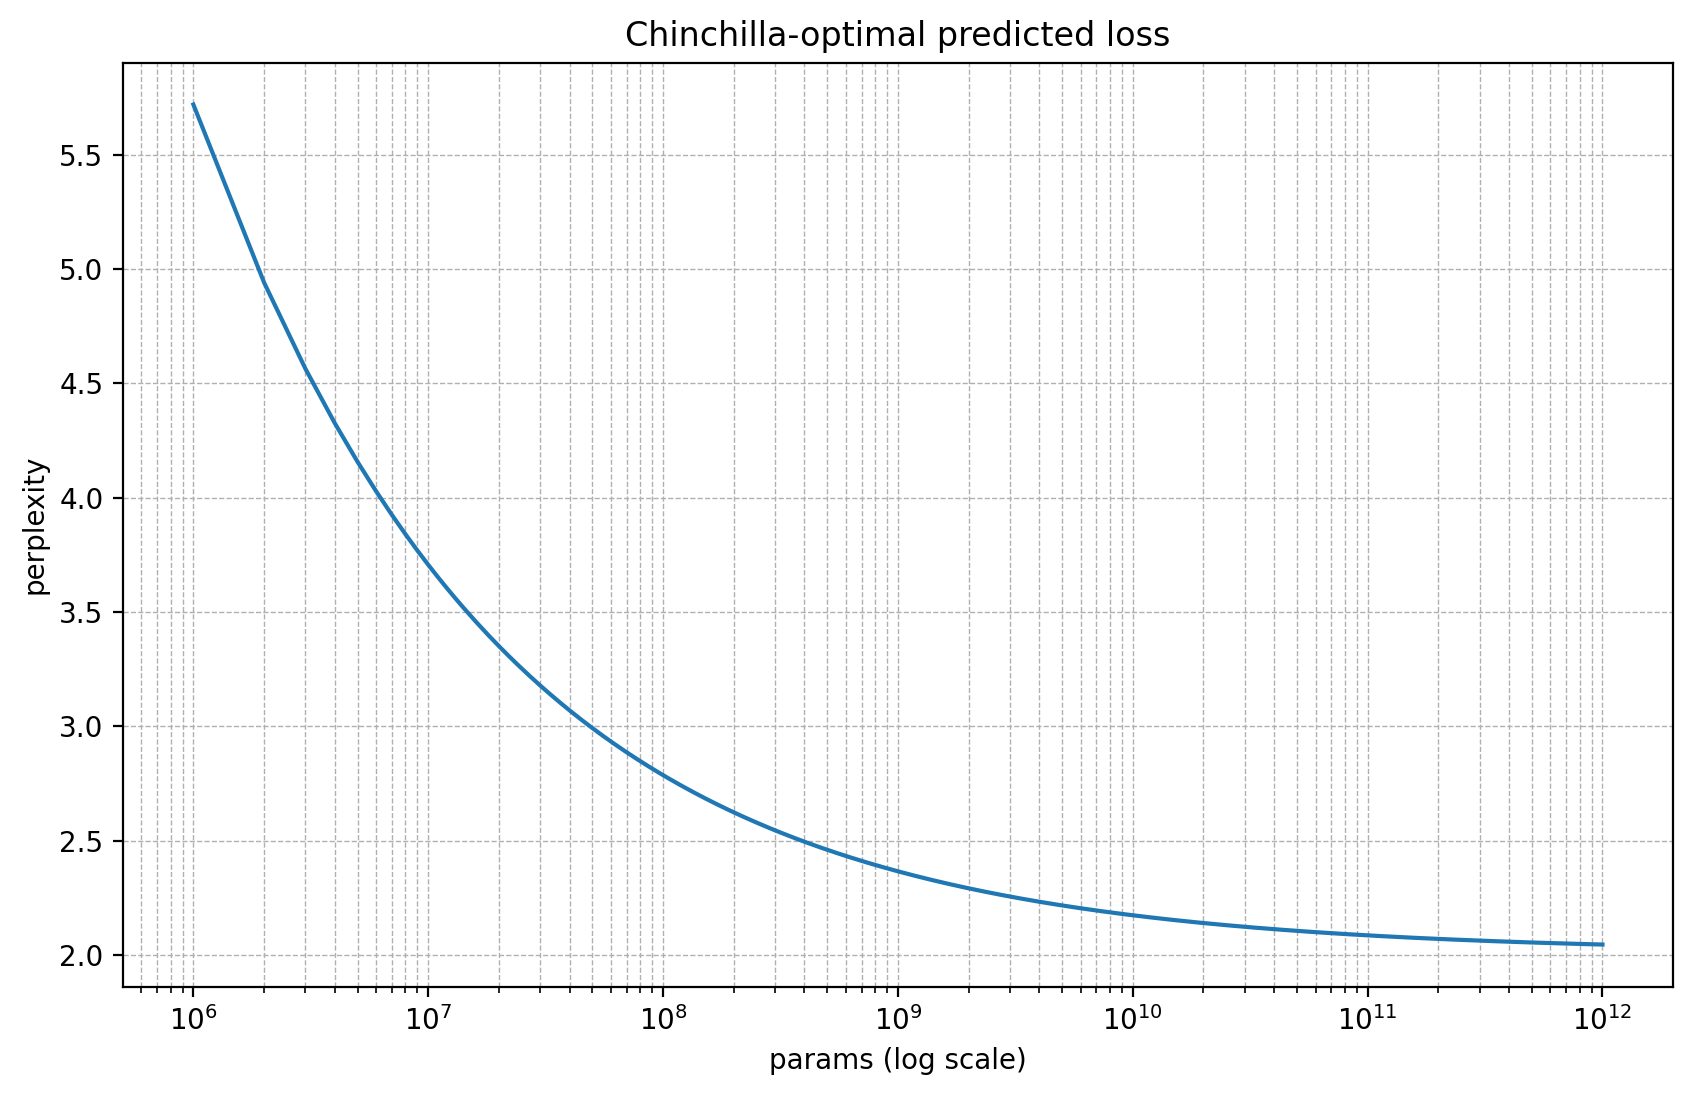

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(n_range, losses)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('params (log scale)')
plt.ylabel('perplexity')
plt.title('Chinchilla-optimal predicted loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()